# ECE4200 - Kaggle competition
### Jorge Calvar (jc2767)

## Imports

In [4]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from pathlib import Path
import tqdm


from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from scipy.fft import fft
from scipy.signal import spectrogram

## Parameters

In [5]:

N_SAMPLES = 50000

TRAIN_DIR = Path('kaggle/input/spoken-digit-pair-recognition/train/train_new')
TEST_DIR = Path('kaggle/input/spoken-digit-pair-recognition/test/test_new')
TRAIN_DIR_43 = Path('kaggle/input/spoken-digit-pair-recognition/train_43')
WORKING_DIR = Path('kaggle/working')

## Exploring

In [6]:
train_labels = pd.read_csv('kaggle/input/spoken-digit-pair-recognition/train.csv', index_col='ID')
train_labels.head()

,Label
ID,
0,21
1,32
2,31
3,31
4,41


In [7]:
sample_sub = pd.read_csv('kaggle/input/spoken-digit-pair-recognition/sample_sub.csv', index_col='ID')
sample_sub.head()

,Label
ID,
0,21
1,21
2,21
3,21
4,21


In [8]:
max_files = []
for d in [TRAIN_DIR, TEST_DIR]:
    max_file = 0
    for f in d.iterdir():
        i = int(f.name[f.name.index('_')+1:-4])
        max_file = np.max([max_file, i])
    max_files.append(max_file)
print(f'Max train file: {max_files[0]}')
print(f'Max test file: {max_files[1]}')

Max train file: 89999
Max test file: 24749


## Functions

In [9]:
def get_audio(i, train=True, dir=None):
    if dir is None:
        dir = TRAIN_DIR if train else TEST_DIR
    if dir == TRAIN_DIR:
        base = 'train'
    else:
        base = 'test'
    file = dir / f'{base}_{i}.wav'
    _, data = wavfile.read(file)
    return data


def convert_dataframe_to_numpy(df):
    for i in range(6000):
        df[f'x_{i}'] = df['data'].apply(lambda r: r[i])
    del df['data']
    array_final = df.to_numpy()
    return array_final


def try_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_val, model.predict(X_val))
    return acc_train, acc_test


def try_models(models, X_train, X_val, y_train, y_val):
    df = pd.DataFrame()
    for model in models:
        acc_train, acc_test = try_model(model, X_train, X_val, y_train, y_val)
        df.loc[len(df), ['Model', 'Train accuracy', 'Validation accuracy']] = [model, acc_train, acc_test]
    return df

## Preprocessing

In [80]:
# TRAIN

n_batch = np.arange(90000)
np.random.shuffle(n_batch)
n_batch = n_batch[:N_SAMPLES]

audios = [get_audio(i) for i in n_batch]
labels = [train_labels.at[i, 'Label'] for i in n_batch]

audios = [data/np.max(data) for data in audios]



#### Testing samples (43)

In [81]:
# Testing samples with label 43 that will be used to train

indexes_43 = [int(f.name[f.name.index('_')+1:f.name.index('.')]) for f in TRAIN_DIR_43.iterdir()]
audios_43 = [get_audio(i, dir=TRAIN_DIR_43) for i in indexes_43]
audios_43 = [data/np.max(data) for data in audios_43]


In [86]:
# Augmentation functions
import librosa

def add_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def add_time_shift(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data


def add_pitch_shift(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def add_speed_change(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)



In [116]:
REPETITIONS_PER_SAMPLE = N_SAMPLES//(9*len(indexes_43))-len(audios_43)

augmented_audios_43 = []

for i in range(REPETITIONS_PER_SAMPLE // 4):
    for j in range(len(indexes_43)):

        data = audios_43[j]

        # Noise
        noise_factor = 0.0015
        new_audio = add_noise(data, noise_factor)
        augmented_audios_43.append(new_audio)

        # Time shift
        shift_max = 0.3
        new_audio = add_time_shift(data, 8000, shift_max, 'right')
        augmented_audios_43.append(new_audio)

        # Pitch shift
        pitch_factor = np.random.randint(-4,5)
        new_audio = add_pitch_shift(data, 8000, pitch_factor)
        augmented_audios_43.append(new_audio)

        # Speed change
        speed_factor = np.random.rand()*0.5+1
        new_audio = add_speed_change(data, speed_factor)
        new_audio = np.concatenate((new_audio, np.zeros(6000-new_audio.size)))
        augmented_audios_43.append(new_audio)




In [160]:
#final_audios = audios + audios_43 + augmented_audios_43
#final_labels = labels + ([43]*(len(audios_43)+len(augmented_audios_43)))
final_audios = audios + audios_43*5
final_labels = labels + ([43]*(len(audios_43)*5))

In [161]:
# Modification

In [162]:
df_x = pd.DataFrame(data={'data': final_audios, 'label': final_labels})
array_final = convert_dataframe_to_numpy(df_x.copy())

In [163]:
X_train, X_val, y_train, y_val = train_test_split(array_final[:, 1:], array_final[:, 0], test_size=0.1)

In [177]:
# TEST

df_test = pd.DataFrame(columns=['data'])
df_test.index.name = 'ID'

for i in range(24750):
    data = get_audio(i, train=False)
    data = data/np.max(data)
    df_test.loc[i, 'data'] = data

# Numpy
X_test = convert_dataframe_to_numpy(df_test.copy())

df_test.head()


,data
ID,
0,"[0.12012085329752495, 0.12765892513809626, 0.0..."
1,"[-0.0043183486634710885, 0.04305393617480675, ..."
2,"[-0.07535019989623706, -0.05340739158299509, -..."
3,"[-0.050355540635395366, -0.04278695028534806, ..."
4,"[-0.10269478438673055, -0.06418042542802209, -..."


## Spectrogram creation


In [178]:
def get_spectrogram(audio, fs=8000):
    _, _, Sxx = spectrogram(audio, fs=fs)
    return Sxx

# TRAIN

df_x2 = df_x.copy()
df_x2['data'] = df_x2['data'].apply(lambda x: get_spectrogram(x))

df_x2.head()

# TEST

df_test2 = df_test.copy()
df_test2['data'] = df_test2['data'].apply(lambda x: get_spectrogram(x))

# Convertimos a numpy
X_test2 = np.zeros((len(df_test2),1)+df_test2.iloc[0,0].shape)
for i, (index, r) in enumerate(df_test2.iterrows()):
    X_test2[i,0] = r['data']


In [165]:
X2 = np.zeros((len(df_x2),1)+df_x2.iloc[0,0].shape)
Y2 = np.zeros((len(X2),))
for i, (index, r) in enumerate(df_x2.iterrows()):
    X2[i,0] = r['data']
    Y2[i] = r['label']

In [166]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, Y2, test_size=0.1)

## PyTorch

In [19]:
import torch
from torch import nn
import torch.nn.functional as F

#### Tensor creation

In [182]:
# TENSOR CREATION


# SET 1: WITHOUT SPECTROGRAM

X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float()

y_train_tensor = torch.from_numpy(y_train.astype(np.int64))
y_val_tensor = torch.from_numpy(y_val.astype(np.int64))

# For initial model
y_train_dict = {}
y_val_dict = {}
# Created later, for unique model
y_train_sep = torch.zeros((y_train_tensor.shape[0], 4), dtype=torch.int64)
y_val_sep = torch.zeros((y_val_tensor.shape[0], 4), dtype=torch.int64)
for i in range(1,5):
    vf = np.vectorize(lambda x: str(i) in str(x))
    y_train_dict[i] = torch.from_numpy((vf(y_train)).astype(np.int64))
    y_val_dict[i] = torch.from_numpy((vf(y_val)).astype(np.int64))
    y_train_sep[:, i - 1] = y_train_dict[i]
    y_val_sep[:, i - 1] = y_val_dict[i]


# SET 2: WITH SPECTROGRAM

X_train2_tensor = torch.from_numpy(X_train2).float()
X_val2_tensor = torch.from_numpy(X_val2).float()
X_test2_tensor = torch.from_numpy(X_test2).float()

y_train2_dict = {}
y_val2_dict = {}
y_train2_sep = torch.zeros((y_train_tensor.shape[0], 4), dtype=torch.int64)
y_val2_sep = torch.zeros((y_val_tensor.shape[0], 4), dtype=torch.int64)
for i in range(1,5):
    vf = np.vectorize(lambda x: str(i) in str(x))
    y_train2_dict[i] = torch.from_numpy((vf(y_train2)).astype(np.int64))
    y_val2_dict[i] = torch.from_numpy((vf(y_val2)).astype(np.int64))
    y_train2_sep[:,i-1] = y_train2_dict[i]
    y_val2_sep[:,i-1] = y_val2_dict[i]



In [183]:
SET = 2

# FINAL SELECTIONS

if SET == 1:
    final_X_train = X_train_tensor
    final_X_val = X_val_tensor
    final_X_test = X_test_tensor
    final_y_train = y_train_dict
    final_y_val = y_val_dict
    final_y_train_sep = y_train_sep
    final_y_val_sep = y_val_sep
    final_y_train_real = y_train
    final_y_val_real = y_val
elif SET == 2:
    final_X_train = X_train2_tensor
    final_X_val = X_val2_tensor
    final_X_test = X_test2_tensor
    final_y_train = y_train2_dict
    final_y_val = y_val2_dict
    final_y_train_sep = y_train2_sep
    final_y_val_sep = y_val2_sep
    final_y_train_real = y_train2
    final_y_val_real = y_val2




## Method 1: 4 different models

#### Model

In [43]:
class Net1(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(500),
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(100),
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(2)
        )

    def forward(self, x):
        #x = self.pool(self.conv1(x))
        #x = self.pool(self.conv2(x))
        return self.layers(x)

class Net2(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(300),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.LazyLinear(300),
            nn.ReLU(),
            nn.LazyLinear(100),
            nn.ReLU(),
            nn.LazyLinear(2)
        )

    def forward(self, x):
        #x = self.pool(self.conv1(x))
        #x = self.pool(self.conv2(x))
        return self.layers(x)




#### Training function

In [68]:

def train_model(model, n_epochs, X_train, y_train, X_test, y_test):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    training_loss = []
    training_acc = []
    testing_acc = []

    continuous_perfect_test = 0

    for i in tqdm.tqdm(range(n_epochs)):

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        training_loss.append(loss)
        training_acc.append(torch.sum(torch.argmax(outputs, dim=1) == y_train)/y_train.shape[0])
        test_acc_i = torch.sum(torch.argmax(model(X_test), dim=1) == y_test)/y_test.shape[0]
        testing_acc.append(test_acc_i)
        if test_acc_i == 1:
            continuous_perfect_test += 1
            if continuous_perfect_test == 10:
                break
        else:
            continuous_perfect_test = 0
        loss.backward()
        optimizer.step()

    return training_loss, training_acc, testing_acc





#### Actual training

C:\Users\jorge\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 100/100 [11:49<00:00,  7.09s/it]


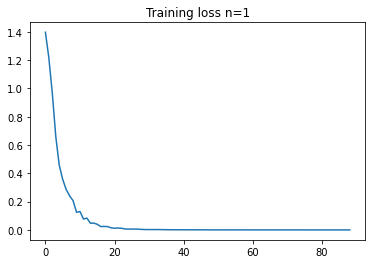

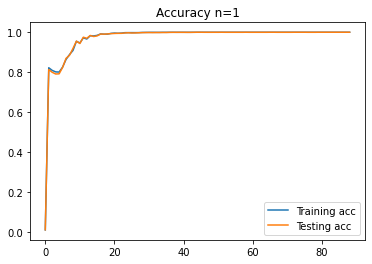

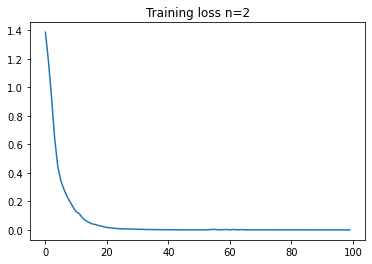

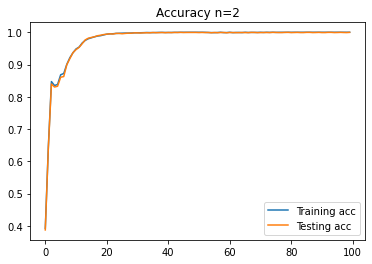

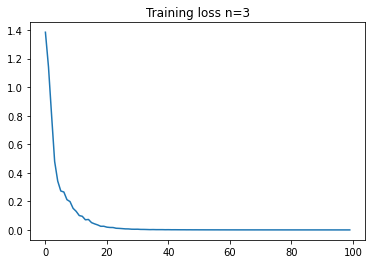

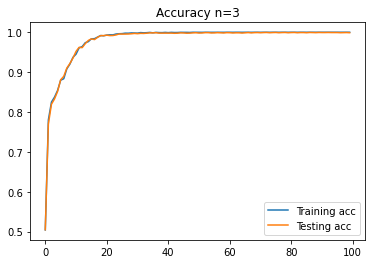

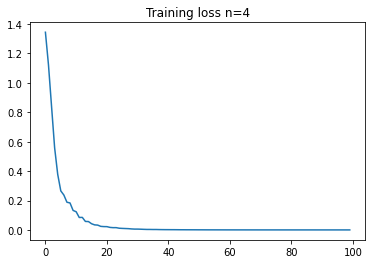

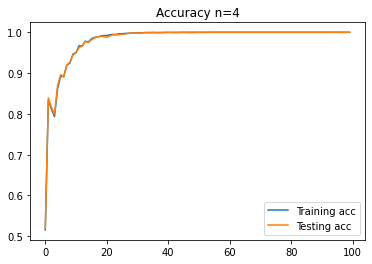

In [44]:
# TRAINING

N_EPOCHS = 100

models = {}
for i in range(1, 5):

    net = Net2()
    training_loss, training_acc, testing_acc = train_model(
                net,
                N_EPOCHS,
                final_X_train,
                final_y_train[i],
                final_X_val,
                final_y_val[i]
    )
    models[i] = net


    plt.figure()
    plt.plot(training_loss)
    plt.title(f'Training loss n={i}')

    plt.figure()
    plt.plot(training_acc, label='Training acc')
    plt.plot(testing_acc, label='Testing acc')
    plt.title(f'Accuracy n={i}')
    plt.legend()

In [238]:
final_X_train.shape


torch.Size([45000, 1, 129, 26])

In [20]:
def get_pred(preds, n):
    pred_i = []
    for i in range(1,5):
        pred_i.append((i, preds[i][n, 1]))
    pred_i.sort(key=lambda x: x[1], reverse=True)
    n1 = pred_i[0][0]
    n2 = pred_i[1][0]
    return 10*max(n1, n2)+min(n1, n2)

### Final training performance

In [45]:
# We calculate predictions for each model

preds = {}
for i in range(1,5):
    output = models[i](final_X_train)
    preds[i] = nn.Softmax(dim=1)(output).detach()


In [46]:
# We obtain final train predictions
df_train_out = pd.DataFrame()
for i in range(final_X_train.shape[0]):
    df_train_out.loc[i, 'Label'] = get_pred(preds, i)
df_train_out.index.name = 'ID'

In [47]:
# We obtain accuracy
acc_train = np.mean(df_train_out.to_numpy().flatten() == final_y_train_real)
acc_train

1.0

### Final validation performance

In [48]:
# We calculate predictions for each model

preds = {}
for i in range(1,5):
    output = models[i](final_X_val)
    preds[i] = nn.Softmax(dim=1)(output).detach()

In [49]:
df_val_out = pd.DataFrame()
for i in range(final_X_val.shape[0]):
    df_val_out.loc[i, 'Label'] = get_pred(preds, i)
df_val_out.index.name = 'ID'

In [50]:
# We obtain accuracy
acc_val = np.mean(df_val_out.to_numpy().flatten() == final_y_val_real)
acc_val

0.9998


## Testing set


In [81]:
# Quick check
df_test2.head()


,data
ID,
0,"[[379.57758, 20923.59, 14166.862, 22814.756, 8..."
1,"[[0.7014259, 1.1677585, 35.454216, 227.3494, 2..."
2,"[[32.615494, 7837.592, 309.223, 11478.009, 659..."
3,"[[38.34697, 3682.0913, 3083.8462, 136.71426, 2..."
4,"[[108.43886, 39.33499, 1278.1526, 3052.5256, 1..."


In [264]:
# Predecimos

preds = {}
for i in range(1, 5):
    output = models[i](final_X_test)
    preds[i] = nn.Softmax(dim=1)(output).detach()


In [265]:
# Creamos el excel final


df_test_out = pd.DataFrame()
for i in df_test2.index:
    df_test_out.loc[i, 'Label'] = get_pred(preds, i)
df_test_out.index.name = 'ID'
df_test_out['Label'] = df_test_out['Label'].astype(int)
df_test_out.to_csv('test_out_0612_v2.csv')


tensor([[4.9942e-06, 9.9999e-01],
        [9.9999e-01, 1.0025e-05],
        [1.9315e-04, 9.9981e-01],
        ...,
        [9.9841e-01, 1.5866e-03],
        [7.0612e-04, 9.9929e-01],
        [9.6816e-01, 3.1844e-02]], grad_fn=<SoftmaxBackward0>)

## Method 2: One model with 4 outputs

#### The model

In [216]:
class Net3(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),

            nn.LazyBatchNorm1d(),
            nn.LazyLinear(400),
            nn.LeakyReLU(),
            nn.Dropout(0.25),

            nn.LazyBatchNorm1d(),
            nn.LazyLinear(400),
            nn.LeakyReLU(),
            nn.Dropout(0.25),

            nn.LazyBatchNorm1d(),
            nn.LazyLinear(4),
            nn.Sigmoid(),
        )

    def forward(self, x):
        #x = self.pool(self.conv1(x))
        #x = self.pool(self.conv2(x))
        return self.layers(x)

##### Training function

In [149]:
def train_model_unique(model, X_train, y_train, X_test, y_test, batch_size, n_epochs, epochs_info):
    criterions = list(nn.BCELoss() for _ in range(4))
    optimizer = torch.optim.Adam(model.parameters())

    training_loss = []
    training_acc = []
    validation_acc = []
    final_training_acc = []
    final_validation_acc = []


    for k in tqdm.tqdm(range(n_epochs)):

        batch_indexes = torch.randint(0,X_train.shape[0], (batch_size,))
        X_train_epoch = X_train[batch_indexes]
        y_train_epoch = y_train[batch_indexes]

        optimizer.zero_grad()
        outputs = model(X_train_epoch)

        l0 = criterions[0](outputs[:,0], y_train_epoch[:,0])
        l1 = criterions[1](outputs[:,1], y_train_epoch[:,1])
        l2 = criterions[2](outputs[:,2], y_train_epoch[:,2])
        l3 = criterions[3](outputs[:,3], y_train_epoch[:,3])
        loss = l0+l1+l2+l3

        if k%epochs_info == 0:

            # INDIVIDUAL ACCURACY

            training_loss.append(loss)
            training_acc.append(torch.sum((torch.round(model(X_train)) == y_train).type(torch.int))/(y_train.shape[0]*4))
            test_acc_i = torch.sum((torch.round(model(X_test)) == y_test).type(torch.int))/(y_test.shape[0]*4)
            validation_acc.append(test_acc_i)

            # FINAL ACCURACY

            # Train accuracy
            pred_train = model(final_X_train).detach().numpy()
            final_pred_train = get_pred_output(pred_train)
            train_acc = np.mean(final_pred_train == final_y_train_real)
            final_training_acc.append(train_acc)

            # Val accuracy
            pred_val = model(final_X_val).detach().numpy()
            final_pred_val = get_pred_output(pred_val)
            val_acc = np.mean(final_pred_val == final_y_val_real)
            final_validation_acc.append(val_acc)



        loss.backward()
        optimizer.step()

    return training_loss, training_acc, validation_acc, final_training_acc, final_validation_acc


In [128]:
def get_pred_output(pred):
    def get_i_pred(pred_i):
        a = list(enumerate(pred_i))
        a.sort(key=lambda x: x[1], reverse=True)
        n1 = a[0][0]+1
        n2 = a[1][0]+1
        return 10*max(n1, n2)+min(n1,n2)
    preds = [get_i_pred(pred[i,:]) for i in range(pred.shape[0])]
    return np.array(preds)

##### Training

In [218]:
# TRAINING

BATCH_SIZE = final_X_train.shape[0]
N_EPOCHS = 500
EPOCHS_INFO = 50 # Each EPOCHS_INFO epochs, output info will be calculated


net = Net3()
training_loss, training_acc, validation_acc, finaL_training_acc, final_validation_acc = train_model_unique(
    net,
    final_X_train,
    final_y_train_sep.type(torch.float),
    final_X_val,
    final_y_val_sep.type(torch.float),
    BATCH_SIZE,
    N_EPOCHS,
    EPOCHS_INFO
)



100%|██████████| 6000/6000 [10:51<00:00,  9.20it/s]  


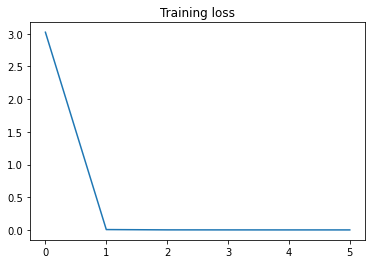

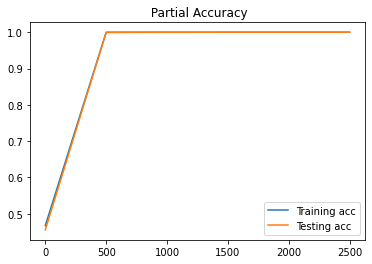

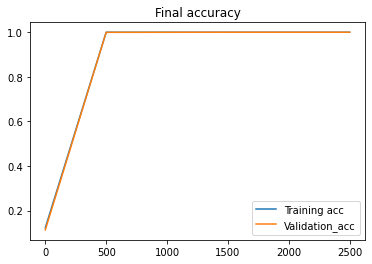

In [210]:

plt.figure()
plt.plot(training_loss)
plt.title(f'Training loss')

x_axis = list(range(0,N_EPOCHS,EPOCHS_INFO))

plt.figure()
plt.plot(x_axis, training_acc, label='Training acc')
plt.plot(x_axis, validation_acc, label='Testing acc')
plt.title(f' Partial Accuracy')
plt.legend()

plt.figure()
plt.plot(x_axis, finaL_training_acc, label='Training acc')
plt.plot(x_axis, final_validation_acc, label='Validation_acc')
plt.title('Final accuracy')
plt.legend()



In [211]:
max(validation_acc)

tensor(1.)

In [212]:
max_final_validation_acc = max(final_validation_acc)
index_max_final_validation_acc = final_validation_acc.index(max_final_validation_acc)*EPOCHS_INFO

print(f'Max final validation accuracy: {max_final_validation_acc}')
print(f'Epoch: {index_max_final_validation_acc}')

Max final validation accuracy: 1.0
Epoch: 1500


#### Test output

In [213]:
try:
    _ = train_acc+1
except:
    train_acc = 0
    val_acc = 0

# Train accuracy
pred_train = net(final_X_train).detach().numpy()
final_pred_train = get_pred_output(pred_train)
previous_train_acc = train_acc
train_acc = np.mean(final_pred_train == final_y_train_real)

# Val accuracy
pred_val = net(final_X_val).detach().numpy()
final_pred_val = get_pred_output(pred_val)
previous_val_acc = val_acc
val_acc = np.mean(final_pred_val == final_y_val_real)

# Output
print(f'Final training accuracy: {round(train_acc*100,6)}% ({round((train_acc-previous_train_acc)*10000,2)}p)')
print(f'Final validation accuracy: {round(val_acc*100,6)}% ({round((val_acc-previous_val_acc)*10000,2)}p)')


Final training accuracy: 100.0% (0.0p)
Final validation accuracy: 100.0% (0.0p)


### Submission

In [214]:
pred_test = net(final_X_test).detach().numpy()
final_pred_test = get_pred_output(pred_test)

In [215]:
# Creamos el excel final

df_test_out = pd.DataFrame(index=df_test2.index, data={'Label':final_pred_test})
df_test_out.index.name = 'ID'
df_test_out['Label'] = df_test_out['Label'].astype(int)
df_test_out.to_csv('test_out_0712_v5.csv')